# Introduction

## Sales Forecasting Model

This repository contains a base sales forecasting model built in Python using the statsmodels library. The model forecasts sales by leveraging key advertising metrics while also incorporating seasonal and special holiday effects through dummy variables. In addition, the model accounts for delayed effects by applying a one-week lag to the Offline Ads variable.

- Data Cleaning and Preprocessing:
Raw data is imported from a CSV file and preprocessed. Date fields are converted to datetime objects, and numeric columns (such as Sales and Digital Ads) are cleaned by removing commas and converting them to appropriate numeric types.
- Model Building:
A multiple linear regression (OLS) model is constructed using advertising variables including TVCM_GPR, Print_Media, Offline_Ads (lagged by one week), and Digital_Ads. To capture seasonal variations, monthly dummy variables (e.g., for February to December) are added. Special holiday dummy variables (for New Year, Golden Week, and Obon) are also incorporated to account for their impact on sales.
- Train/Test Split and Evaluation:
The historical “Actual” sales data is split into training (80%) and testing (20%) sets. The model is trained on the training set and evaluated on the test set using metrics like RMSE and R² to assess its predictive performance.
- Forecasting:
After model evaluation, the trained model is applied to forecast future sales for records marked as “Forecast”. The forecasted values are printed as well as visualized alongside the historical data.

This base model is intended as a clear framework to help you understand how to integrate advertising metrics, seasonal effects, and time-lagged predictors into a sales forecasting model. Although the predictive accuracy may be moderate at this stage, it provides a solid foundation for further refinement and enhancement.

In [1]:
!pip install japanize_matplotlib
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
input_file ="../data/sales_data.csv"
df = pd.read_csv(input_file)
df.head()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
0,9/7/15,"5,554,981",58.86750,20340000,5890000,"23,080",Actual
1,9/14/15,"6,071,669",235.18125,15470000,5740000,"29,979",Actual
2,9/21/15,"5,798,657",252.18375,8325000,0,"23,784",Actual
3,9/28/15,"6,235,157",75.25500,0,0,"26,732",Actual
4,10/5/15,"6,861,105",0.00000,0,0,"28,823",Actual


In [3]:
df.tail()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
116,11/27/17,NaN,79.3800,15450000,0,"31,769",Forecast
117,12/4/17,NaN,41.4900,9930000,0,"34,799",Forecast
118,12/11/17,NaN,0.0000,16280000,0,"31,907",Forecast
119,12/18/17,NaN,81.2625,13350000,5890000,"31,048",Forecast
120,12/25/17,NaN,44.5725,15030000,9150000,"59,196",Forecast


# Preprocess

In [4]:
df.isnull().sum()

Date            0
Sales          16
TVCM_GPR        0
Print_Media     0
Offline_Ads     0
Digital_Ads     0
Record_Type     0
dtype: int64

In [5]:
df.duplicated(subset=['Date']).sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        105 non-null    object 
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    object 
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ KB


In [7]:
df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        121 non-null    int64  
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    int64  
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.7+ KB


# Add Monthly Dummy

In [8]:
import pandas as pd
import numpy as np

df['Date'] = pd.to_datetime(df['Date'])

def count_days_in_week(start_date):
    counts = {f'{i}月': 0 for i in range(1, 13)}
    for i in range(7):
        current_day = start_date + pd.Timedelta(days=i)
        month_str = f'{current_day.month}月'
        counts[month_str] += 1
    return pd.Series(counts)

dummy_columns = [f'{i}月' for i in range(1, 13)]

if not all(col in df.columns for col in dummy_columns):
    month_dummies = df['Date'].apply(count_days_in_week)
    df = pd.concat([df, month_dummies], axis=1)
else:
    print("Monthly dummy columns already exist. Skipping concatenation.")

print(df.tail(20))

          Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
101 2017-08-14  6424589    0.00000     12785000            0        51122   
102 2017-08-21  5308052   39.29250     12510000            0        45519   
103 2017-08-28  5637103    0.00000     12890000            0        33703   
104 2017-09-04  6250997   36.44250     15080000            0        38845   
105 2017-09-11        0  235.18125     15470000      5740000        23830   
106 2017-09-18        0  252.18375      8325000            0        26072   
107 2017-09-25        0   75.25500            0            0        29948   
108 2017-10-02        0    0.00000            0            0        34220   
109 2017-10-09        0   44.62125            0            0        29145   
110 2017-10-16        0   50.16750            0            0        25991   
111 2017-10-23        0   46.60875            0      8360000        18571   
112 2017-10-30        0  115.46625     15900000      8710000        32704   

/var/folders/_n/cr9xqtgn70g_tclcyk9hd0nw0000gn/T/ipykernel_49631/3108959876.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


# Add Public Holiday Dummy

In [9]:
from datetime import datetime, timedelta

holiday_ranges = {
    '正月': [
        (datetime(2015,12,28), datetime(2016,1,3)),
        (datetime(2016,12,26), datetime(2017,1,3)),
        (datetime(2017,12,25), datetime(2018,1,3)),  # Extend if needed
    ],
    'GW': [
        (datetime(2015,4,29), datetime(2015,5,5)),
        (datetime(2016,4,29), datetime(2016,5,5)),
        (datetime(2017,4,29), datetime(2017,5,5)),
    ],
    'お盆': [
        (datetime(2015,8,13), datetime(2015,8,16)),
        (datetime(2016,8,13), datetime(2016,8,16)),
        (datetime(2017,8,13), datetime(2017,8,16)),
    ]
}

df['正月'] = 0
df['GW'] = 0
df['お盆'] = 0

def intersects_holiday(week_start, holiday_start, holiday_end):
    """
    Returns True if the 7-day window [week_start, week_start+6] intersects
    with [holiday_start, holiday_end].
    """
    week_end = week_start + pd.Timedelta(days=6)
    return not (week_end < holiday_start or week_start > holiday_end)

for idx, row in df.iterrows():
    week_start = row['Date']
    
    for holiday_name, ranges in holiday_ranges.items():
        for (start_date, end_date) in ranges:
            if intersects_holiday(week_start, start_date, end_date):
                df.loc[idx, holiday_name] = 1
                break  

print(df.head(15))



         Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
0  2015-09-07  5554981   58.86750     20340000      5890000        23080   
1  2015-09-14  6071669  235.18125     15470000      5740000        29979   
2  2015-09-21  5798657  252.18375      8325000            0        23784   
3  2015-09-28  6235157   75.25500            0            0        26732   
4  2015-10-05  6861105    0.00000            0            0        28823   
5  2015-10-12  5987676   44.62125            0            0        24929   
6  2015-10-19  5975534   50.16750            0            0        29918   
7  2015-10-26  5996415   46.60875            0      8360000        25121   
8  2015-11-02  5712700  115.46625     15900000      8710000        25303   
9  2015-11-09  5863532  185.66250      7835000      9050000        26184   
10 2015-11-16  6169764  223.53375      8405000      9600000        32256   
11 2015-11-23  6721802  188.91000     23295000      4690000        33227   
12 2015-11-3

# Add Time lag

In [10]:
df['Offline_Ads_Lag1'] = df['Offline_Ads'].shift(1)
df['Offline_Ads_Lag1'] = df['Offline_Ads_Lag1'].fillna(0)

print(df[['Date', 'Offline_Ads', 'Offline_Ads_Lag1']].head(10))

        Date  Offline_Ads  Offline_Ads_Lag1
0 2015-09-07      5890000               0.0
1 2015-09-14      5740000         5890000.0
2 2015-09-21            0         5740000.0
3 2015-09-28            0               0.0
4 2015-10-05            0               0.0
5 2015-10-12            0               0.0
6 2015-10-19            0               0.0
7 2015-10-26      8360000               0.0
8 2015-11-02      8710000         8360000.0
9 2015-11-09      9050000         8710000.0


# Split Actual and Forecast Data

In [11]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

# Regression Model

In [12]:
Y_actual = df_actual['Sales']
monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_actual = df_actual[['TVCM_GPR', 'Print_Media', 'Offline_Ads_Lag1', 'Digital_Ads'] + monthly_dummy + holiday_dummy]
X_actual = sm.add_constant(X_actual)  # Add intercept

X_train, X_test, y_train, y_test = train_test_split(X_actual, Y_actual, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
print("Training Model Summary:")
print(model.summary())

y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print("Test RMSE:", test_rmse)
print("Test R-squared:", test_r2)

Training Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     10.47
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           5.46e-13
Time:                        10:39:47   Log-Likelihood:                -1220.8
No. Observations:                  84   AIC:                             2480.
Df Residuals:                      65   BIC:                             2526.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const           

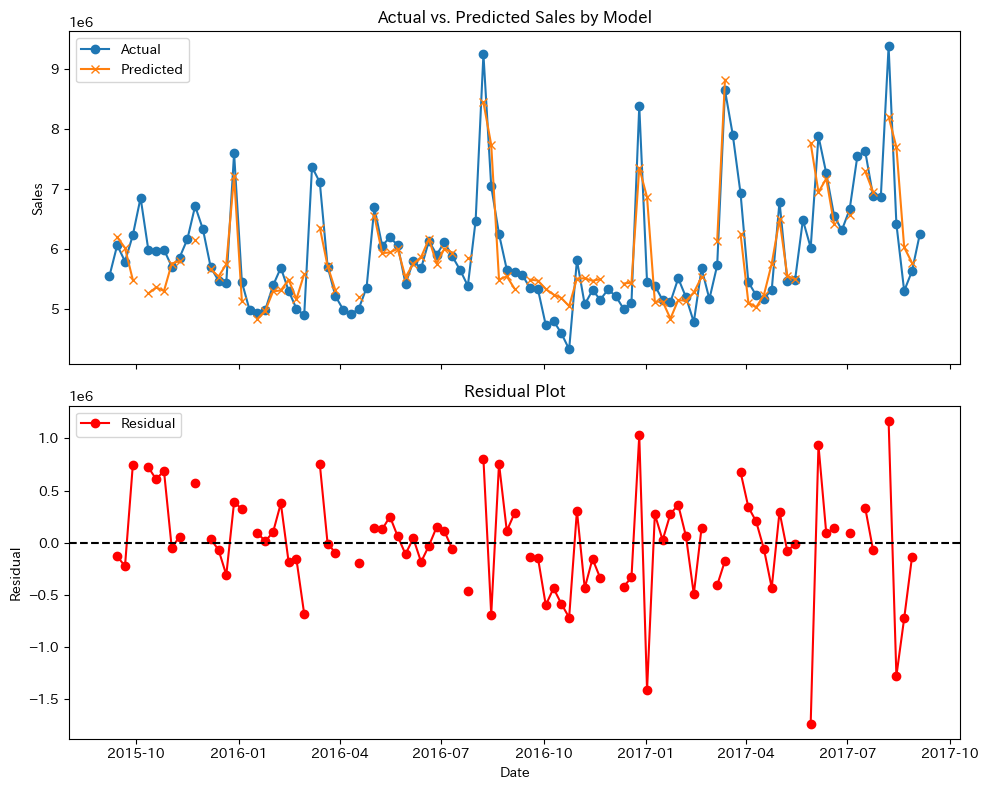

In [13]:
df_actual['Predicted'] = model.fittedvalues
df_actual['Residual'] = model.resid

df_actual.sort_values('Date', inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(df_actual['Date'], df_actual['Sales'], label='Actual', marker='o')
axes[0].plot(df_actual['Date'], df_actual['Predicted'], label='Predicted', marker='x')
axes[0].set_ylabel('Sales')
axes[0].set_title('Actual vs. Predicted Sales by Model')
axes[0].legend()

axes[1].plot(df_actual['Date'], df_actual['Residual'], label='Residual', color='red', marker='o')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].set_title('Residual Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Insight

1. Overall Model Fit and Predictive Performance:
- Training Fit: The model explains about 78% of the variance in Sales (R² = 0.778, Adjusted R² = 0.716) on the training data, which is quite strong.
- Test Performance: However, on the test set, the performance drops significantly, with a Test R² of approximately 0.414 and a Test RMSE of about 668,949. This indicates that the model explains only around 41% of the variance in unseen data, suggesting potential issues with overfitting or insufficient model generalization.

2. Key Predictor Effects:
- TVCM_GPR: The coefficient is around 2117 (p = 0.023), indicating that higher TVCM_GPR is associated with increased Sales.
- Print_Media: The positive and significant coefficient (≈ 0.0146, p = 0.022) implies that higher spending on print media correlates with higher Sales.
- Offline_Ads_Lag1: The lagged Offline Ads variable has a negative coefficient of about -0.0149, but it is not statistically significant (p = 0.459). This suggests that shifting Offline Ads by one week did not yield a significant impact on Sales in this model.
- Digital_Ads: With a coefficient of approximately 18.19 (p = 0.007), Digital Ads have a strong and significant positive effect on Sales.
- Holiday Dummies: The holiday variables (正月, GW, and お盆) are important. Notably, 正月 (p < 0.001) and お盆 (p = 0.001) are highly significant, while GW is marginally significant (p ≈ 0.051), indicating that these periods have a substantial impact on Sales.

3. Diagnostic Observations:
- Multicollinearity: The condition number is very high (≈1.20e+08), suggesting severe multicollinearity among the predictors. This may lead to unstable coefficient estimates and warrants further investigation or variable selection/regularization techniques.
- Residual Diagnostics: The Omnibus and Jarque-Bera tests suggest some deviation from normality, although the Durbin-Watson statistic (2.389) indicates that autocorrelation in the residuals is not a major issue.

4. Overall Insight:
While the model fits the training data well, its predictive performance on the test set is moderate, explaining only about 41% of the variance. The significant positive effects of TVCM_GPR, Print_Media, and Digital_Ads underscore their importance in driving Sales. In contrast, applying a one-week lag to Offline_Ads did not yield a significant effect, suggesting that its delayed impact might be less pronounced or that a different lag structure should be explored. The significant influence of holiday dummies further confirms that special periods like New Year and Obon play a vital role in shaping sales patterns. Future improvements might focus on addressing multicollinearity and exploring alternative modeling approaches to boost predictive accuracy.

This summary provides a comprehensive view of the model’s performance, highlighting both its strengths and areas for further refinement.

# Forecast

Forecast Results:
      Date  Forecast_Sales
2017-09-11    6.179898e+06
2017-09-18    6.066576e+06
2017-09-25    5.682884e+06
2017-10-02    5.339879e+06
2017-10-09    5.342017e+06
2017-10-16    5.296383e+06
2017-10-23    5.153873e+06
2017-10-30    5.832120e+06
2017-11-06    5.857240e+06
2017-11-13    5.781008e+06
2017-11-20    5.967305e+06
2017-11-27    5.775265e+06
2017-12-04    5.634533e+06
2017-12-11    5.586943e+06
2017-12-18    5.700498e+06
2017-12-25    7.582289e+06


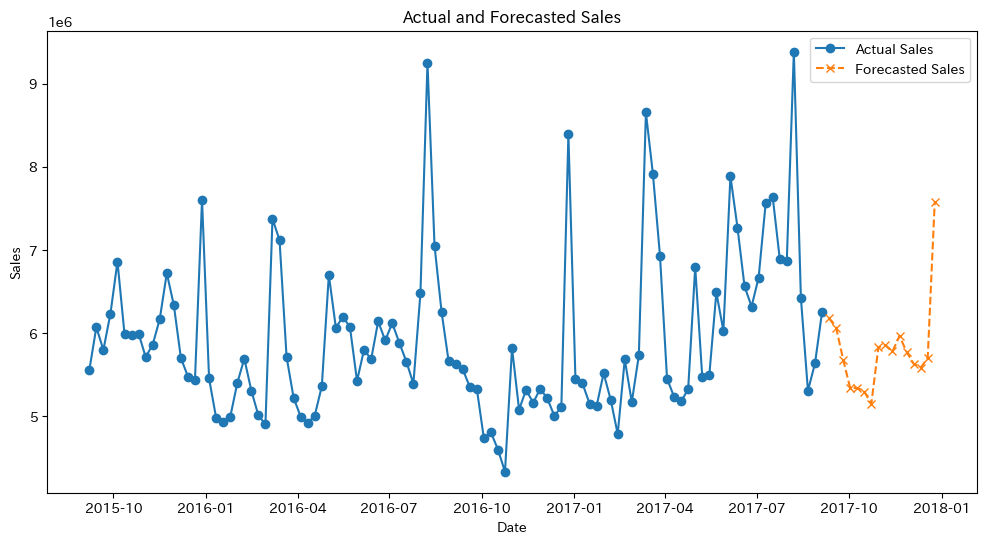

In [14]:
df_actual_combined = pd.concat([df_actual.loc[X_train.index], df_actual.loc[X_test.index]])
df_actual_combined = df_actual_combined.sort_values('Date')

monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_forecast = df_forecast[['TVCM_GPR', 'Print_Media', 'Offline_Ads_Lag1', 'Digital_Ads'] + monthly_dummy + holiday_dummy]
X_forecast = sm.add_constant(X_forecast)

df_forecast['Forecast_Sales'] = model.predict(X_forecast)

df_combined = pd.concat([df_actual_combined, df_forecast])
df_combined = df_combined.sort_values('Date')

print("Forecast Results:")
print(df_forecast[['Date', 'Forecast_Sales']].to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_actual_combined['Date'], df_actual_combined['Sales'], label='Actual Sales', marker='o')
plt.plot(df_forecast['Date'], df_forecast['Forecast_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Forecasted Sales')
plt.legend()
plt.show()